# Deep Deterministic Policy Gradient


In [1]:
from collections import namedtuple, deque
from itertools import count
import random
import copy

import gym
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

eps = np.finfo(np.float32).eps.item()

In [2]:
# ハイパラ
N_EPISODES = 200
N_HIDDEN = 248
gamma = 0.99
tau = 0.005
rb_size = 1000000
replay_start_size = 128
batch_size = 128

env = gym.make('Pendulum-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.shape[0]
reward_threshold = env.spec.reward_threshold


In [3]:
class Actor(nn.Module):
    def __init__(self, in_dim, out_dim, upper_bound, h_dim=64):
        super(Actor, self).__init__()
        self.upper = upper_bound
        self.l1 = nn.Linear(in_dim, h_dim)
        self.l2 = nn.Linear(h_dim, h_dim)
        self.l3 = nn.Linear(h_dim, out_dim)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.upper * F.tanh(self.l3(h)) # 行動値を[-high, high]に制限
        return h

class Critic(nn.Module):
    def __init__(self, in_dim, out_dim=1, action_dim=1, h_dim=64):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(in_dim + action_dim, h_dim)
        self.l2 = nn.Linear(h_dim, h_dim)
        self.l3 = nn.Linear(h_dim, out_dim)
    
    def forward(self, s, a):
        h = F.relu(self.l1(torch.cat([s, a], -1)))
        h = F.relu(self.l2(h))
        v = self.l3(h)
        return v

In [4]:
upper_bound = env.action_space.high[0]
actor = Actor(obs_size, n_actions, upper_bound)
critic = Critic(obs_size)

target_act = Actor(obs_size, n_actions, upper_bound)
target_crit = Critic(obs_size)

target_act.load_state_dict(actor.state_dict()) # パラメーターのコピー
target_crit.load_state_dict(critic.state_dict())
target_act.eval()
target_crit.eval()

opt_act = optim.Adam(actor.parameters(), lr=1e-4)
opt_crit = optim.Adam(critic.parameters(), lr=1e-3)

replay_buffer = deque(maxlen=rb_size)

In [5]:
def update_policy(actor, critic, target_act, target_crit, replay_buffer):
    sample_indices = random.sample(range(len(replay_buffer)), batch_size)
    samples = [replay_buffer[i] for i in sample_indices]

    state = torch.stack([sample[0] for sample in samples]).float()
    action = torch.tensor([sample[1] for sample in samples]).float()
    reward = torch.tensor([[sample[2]] for sample in samples]).float()
    done = torch.tensor([[sample[3]] for sample in samples]).float()
    n_state  = torch.Tensor([sample[4] for sample in samples]).float()

    # criticの更新（誤差の計算）
    next_Q = target_crit(n_state, target_act(n_state)).detach()
    target_Q = reward + gamma * (1 - batch_done) * next_Q
    current_Q = critic(state, action)
    loss_crit = F.smooth_l1_loss(current_Q, target_Q)
    critic_losses.append(loss_crit.item())

    # criticの更新
    opt_crit.zero_grad()
    loss_crit.backward()
    opt_crit.step()

    # actorの更新. 最小化= -最大化
    loss_act = - critic(state, actor(state)).mean()
    actor_losses.append(loss_act.item())

    # actorの更新
    opt_act.zero_grad()
    loss_act.backward()
    opt_act.step()


    # target networkの更新
    for param, target_param in zip(critic.parameters(), target_crit.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    for param, target_param in zip(actor.parameters(), target_act.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [6]:
reward_history = []
for ep in range(N_EPISODES):
    state = env.reset()
    done = False
    R = 0
    critic_losses = []
    actor_losses = []

    while not done:
        state = torch.tensor(state).float()
        action = actor(state).item()
        action = np.clip(action + np.random.normal(0, 0.1), env.action_space.low, env.action_space.high)

        n_state, reward, done, _ = env.step(action)
        R += reward

        # 状態遷移を保存
        replay_buffer.append((state, action, reward, done, n_state))
        state = n_state

        # replay_bufferにある程度たまったらactor-criticを更新
        if len(replay_buffer) >= replay_start_size:
            update_policy(actor, critic, target_act, target_crit, replay_buffer)
      
    reward_history.append(R)
    if ep % 50 == 0:
        print('Episode: {},\t Total Reward: {:2f}'.format(ep, R))

Episode: 0,	 Total Reward: -1295.460931
Episode: 50,	 Total Reward: -258.373161
Episode: 100,	 Total Reward: -115.468265
Episode: 150,	 Total Reward: -126.896873


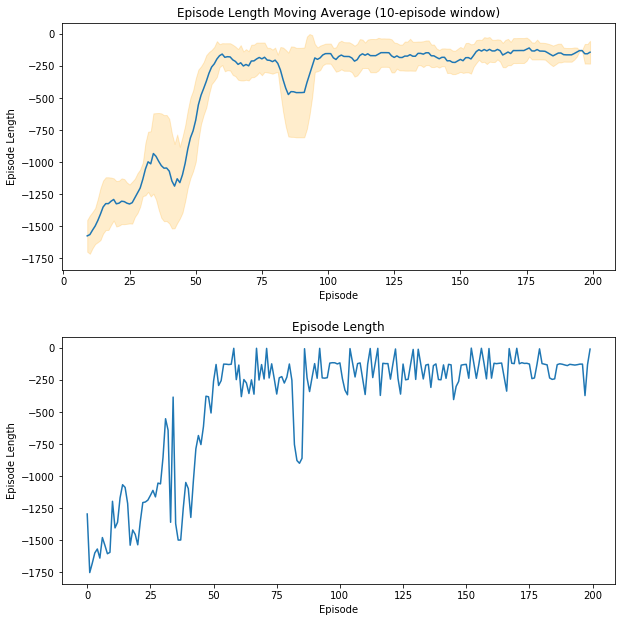

In [11]:
window = int(N_EPISODES/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9])
rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)), rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
fig.savefig('images/ddpg_train.png')
plt.show()